In [1]:
from generate_maps import load_s3dis_point_cloud, get_topologial_map

file_path = 'data/noXYZ_area_5a_no_xyz/area_5a/3d/pointcloud.mat'  
point_sum_points, point_sum_colors, scene_names = load_s3dis_point_cloud(file_path)
print("success load!")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Keys in the .mat file: ['Area_5a']
Processing conferenceRoom_1...
Processing conferenceRoom_2...
Processing conferenceRoom_3...
Processing hallway_1...
Processing hallway_2...
Processing hallway_3...
Processing hallway_4...
Processing hallway_5...
Processing hallway_6...
Processing lobby_1...
Processing hallway_7...
Processing hallway_8...
Processing hallway_9...
Processing hallway_10...
Processing hallway_11...
Processing hallway_12...
Processing hallway_13...
Processing hallway_14...
Processing hallway_15...
Processing office_1...
Processing office_2...
Processing office_3...
Processing office_4...
Processing office_5...
Processing office_6...
Processing office_7...
Processing office_8...
Processing office_9...
Processing office_10...
Processing office_11...
Processing office_12...
Processing office_13...
Processing o

In [2]:
for i, name in enumerate(scene_names):
    if "lobby" in name:
        del point_sum_points[i]
        del point_sum_colors[i]
        del scene_names[i]

In [3]:
import generate_maps
import importlib
importlib.reload(generate_maps)

top_view_map, obstacle_map, separate_obstacle_map, all_centers = generate_maps.get_top_view_map(point_sum_points, point_sum_colors, scene_names, resolution=0.02)


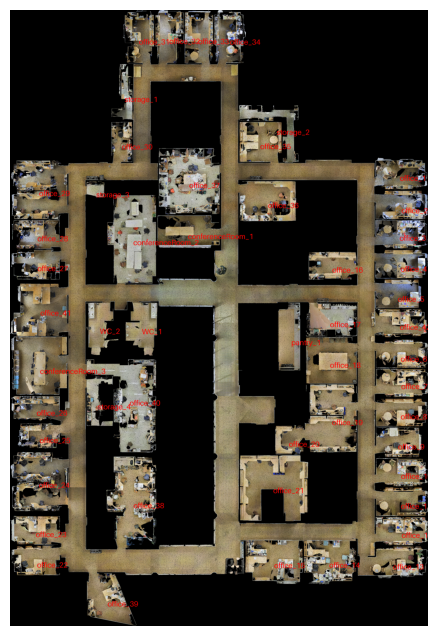

In [4]:
import path_finding
importlib.reload(path_finding)
import matplotlib.pyplot as plt

top_view_map_with_name = path_finding.write_scene_name(top_view_map, all_centers)
plt.figure(figsize=(10, 8)) 
plt.imshow(top_view_map_with_name)
plt.axis('off')  # 隐藏坐标轴
plt.show()

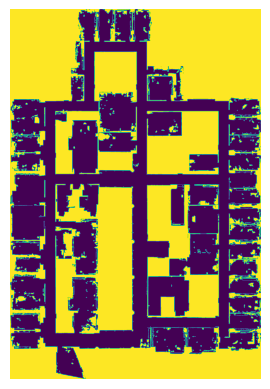

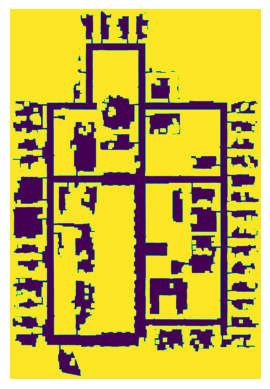

In [5]:
import cv2
import matplotlib.pyplot as plt

kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(30, 30))
ob_map = cv2.dilate((obstacle_map).astype('uint8'), kernel)


plt.imshow(obstacle_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

plt.imshow(ob_map)
plt.axis('off')  # 隐藏坐标轴
plt.show()

In [6]:
importlib.reload(generate_maps)
# build topo map
# G = generate_maps.get_topologial_map(point_sum_points, scene_names)
# graph_show(G)


<module 'generate_maps' from '/home/ybg/Project/Hidden-Info-Nav/generate_maps.py'>

success load!


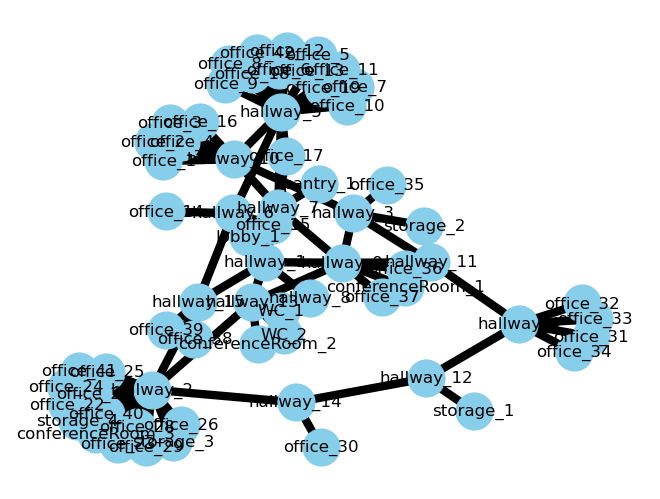

In [7]:

import os
import numpy as np
import pickle

filename = "5a"

# print('Saving model to {}...'.format("saved_maps/"))
# if not os.path.exists("saved_maps/"):
#     os.makedirs("saved_maps/")
    
# graph_serialized = pickle.dumps(G)
# np.savez("saved_maps/" + filename +'_arrays.npz', graph=graph_serialized)
# print('Finished.')

file_path = f"saved_maps/{filename}_arrays.npz"  
data = np.load(file_path, allow_pickle=True)
graph_serialized = data['graph'].item()
G_loaded = pickle.loads(graph_serialized)
print("success load!")

G_loaded.remove_edge('WC_2', 'hallway_2')

path_finding.graph_show(G_loaded)

In [34]:
import networkx as nx
import cv2
import numpy as np
from io import BytesIO
import os

importlib.reload(path_finding)

def get_all_candidate_maps(source_node, target_node):
    all_topo_paths = path_finding.get_all_simple_paths(G_loaded, source_node, target_node)
        
    all_geo_paths = path_finding.path_plan_from_topo_graph(all_topo_paths, obstacle_map, all_centers)

    save_directory = f"map_with_path/area_{filename}/{source_node}-{target_node}/"
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
        
    # show paths in map
    candidate_map_list = []
    for i, geo_path in enumerate(all_geo_paths):
        map_with_path = np.array(top_view_map_with_name).copy()
        x_indices, y_indices = zip(*geo_path)
        path_map = np.zeros(obstacle_map.shape)
        path_map[x_indices, y_indices] = 1
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(15, 15))
        path_map = cv2.dilate((path_map).astype('uint8'), kernel)
        map_with_path[path_map == 1] = [255, 0 , 0]
        
        map_with_path = path_finding.write_number_for_large(map_with_path, i)
        buffered = BytesIO()
        map_with_path.save(buffered, format="JPEG")
        candidate_map_list.append(buffered)

        # 使用 Matplotlib 显示图像
        # 使用 Matplotlib 显示图像
        
        map_with_path.save(save_directory+f"vis_{i}.png")
        plt.imshow(map_with_path)
        plt.axis('off')  # 隐藏坐标轴
        plt.show()
        
    return candidate_map_list, all_geo_paths

In [9]:
importlib.reload(path_finding)
from PIL import Image

def get_metric(source_node, target_node, all_geo_paths):
    
    evaluation_map = path_finding.get_evaulation_map(separate_obstacle_map, source_node, target_node, scene_names, 15)

    office_obstacle_map_array = np.array(separate_obstacle_map)
    office_obstacle_map = np.max(office_obstacle_map_array, axis=0)

    # plt.imshow(evaluation_map)
    # plt.axis('off')  # 隐藏坐标轴
    # plt.show()

    privacy_value_list = []
    distance_list = []
    for i, geo_path in enumerate(all_geo_paths):
        x_indices, y_indices = zip(*geo_path)
        # print(gaussian_modulation[x_indices[0], y_indices[0]])
        print("value: ", sum(evaluation_map[x_indices, y_indices]))
        print("distance: ", len(geo_path))
        privacy_value_list.append(sum(evaluation_map[x_indices, y_indices]))
        distance_list.append(len(geo_path))
        
    return privacy_value_list, distance_list

All paths from node office_3 to node office_13 :
2 ['office_3', 'office_13']
3 ['office_3', 'hallway_7', 'office_13']
6 ['office_3', 'hallway_3', 'hallway_9', 'hallway_1', 'hallway_6', 'office_13']
8 ['office_3', 'hallway_3', 'hallway_9', 'hallway_13', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13']
10 ['office_3', 'hallway_3', 'hallway_11', 'hallway_4', 'hallway_12', 'hallway_14', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13']
11 ['office_3', 'hallway_3', 'hallway_11', 'hallway_4', 'hallway_12', 'hallway_14', 'hallway_2', 'hallway_13', 'hallway_1', 'hallway_6', 'office_13']
6
[['office_3', 'office_13'], ['office_3', 'hallway_7', 'office_13'], ['office_3', 'hallway_3', 'hallway_9', 'hallway_1', 'hallway_6', 'office_13'], ['office_3', 'hallway_3', 'hallway_9', 'hallway_13', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13'], ['office_3', 'hallway_3', 'hallway_11', 'hallway_4', 'hallway_12', 'hallway_14', 'hallway_2', 'hallway_15', 'hallway_6', 'office_13']]
['office_3', 'of

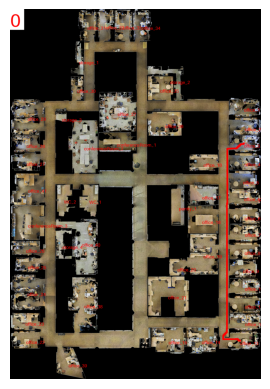

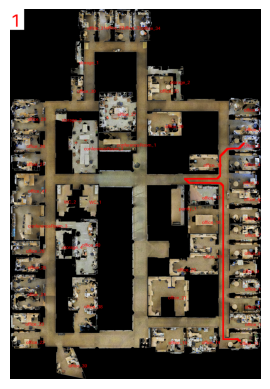

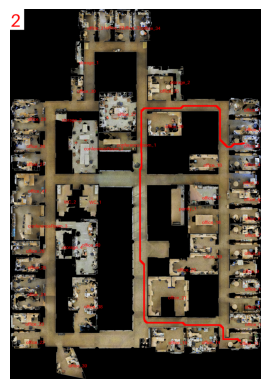

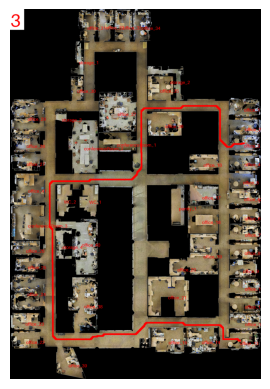

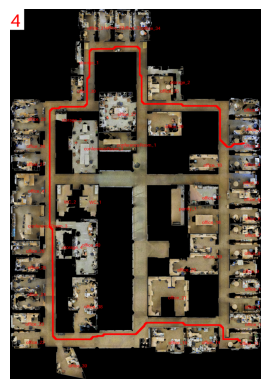

value:  1321.950932370782
distance:  2009
value:  1221.1605540029952
distance:  2580
value:  1109.4908379294095
distance:  4030
value:  1898.9923979392513
distance:  5698
value:  2370.8461342277
distance:  6727
gpt-4o response: 
{
    "observation": "The task involves selecting a path that ensures the secure and private transportation of a classified file between offices. The maps provided show different routes marked with red lines, each passing through various office environments.",
    "reason": "Path 2 is selected as the optimal route for transporting the classified file. This path avoids high-traffic areas like the central corridors and minimizes exposure by primarily navigating through less populated office areas. The other paths, such as Path 0 and Path 1, traverse more central and potentially busier areas, which could increase the risk of accidental exposure of the classified file. Path 3 and Path 4, while similar to Path 2, are longer and pass closer to more offices, which mig

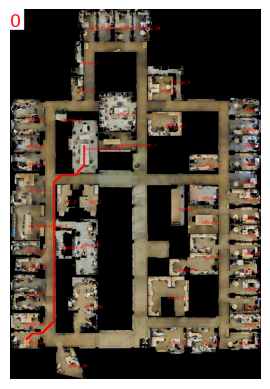

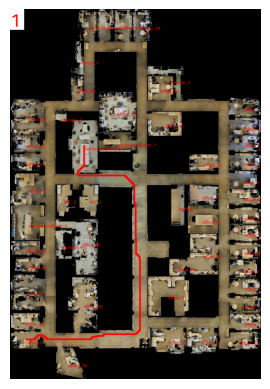

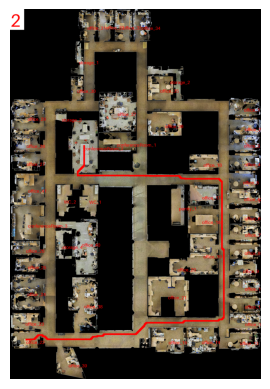

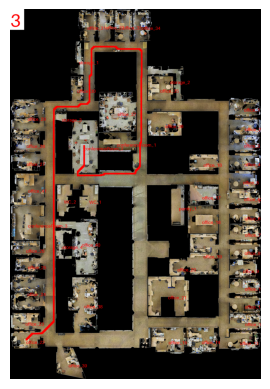

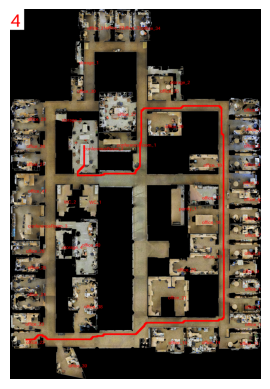

value:  459.5994455474043
distance:  1953
value:  220.10030511985192
distance:  3096
value:  1523.0995261565317
distance:  4559
value:  1345.3599894839833
distance:  5267
value:  2169.674951314998
distance:  5719
gpt-4o response: 
{
    "observation": "The task involves selecting an optimal path for transporting fragile equipment from an office to a conference room. The paths provided in the maps pass through various office areas, storage rooms, and corridors.",
    "reason": "Path 2 is selected as the optimal path for transporting the fragile equipment. This path avoids high-traffic office areas and takes a more direct route through less crowded corridors and storage areas, minimizing the risk of accidental bumps or drops. Paths 0, 1, 3, and 4, while viable, pass through more office areas which could potentially have more human activity and obstacles, increasing the risk to the fragile equipment.",
    "self-critique": "While Path 2 is chosen for its lesser interaction with crowded of

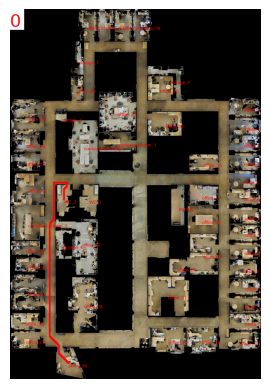

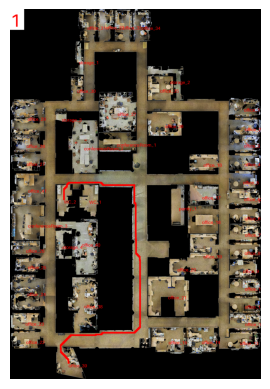

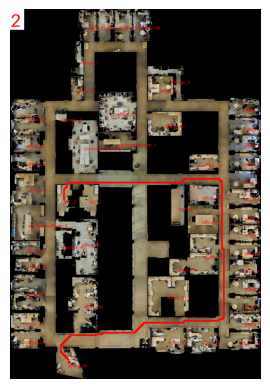

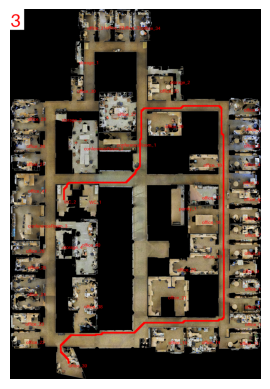

value:  599.2320098616325
distance:  1888
value:  235.20239676855698
distance:  2882
value:  1547.8515288250078
distance:  4364
value:  2186.5529757710624
distance:  5524
gpt-4o response: 
{
    "observation": "The task involves selecting a path that ensures the privacy and safety of transporting private medicine from an office to the bathroom. The maps show four different paths (0, 1, 2, 3) through an office layout with various rooms and corridors.",
    "reason": "Path 0 is the most suitable for this task. It starts from the office, moves through a less crowded area with fewer offices and directly enters the bathroom (WC_1). This path minimizes exposure to busy office areas and avoids unnecessary detours, thus maintaining privacy and reducing the risk of the medicine being seen by many people. Paths 1, 2, and 3, although similar, pass through slightly more populated office areas or take a longer route, which could potentially compromise the privacy of the medicine transport.",
    "s

In [30]:
import chat_utils
import ast
import concurrent.futures
from collections import Counter
import system_prompt
importlib.reload(chat_utils)
importlib.reload(system_prompt)
importlib.reload(path_finding)

num_samples = 5
navigation_instruct1 = "send a classified file from an office to another office"
navigation_instruct2 = "send a fragile equipment from an office to a conference room"
navigation_instruct3 = "send a private medicine from an office to the bathroom"

source_nodes = ["office_3", "office_22", "office_39"]
target_nodes = ["office_13", "conferenceRoom_2", "WC_2"]
# source_nodes = ["office_39"]
# target_nodes = ["WC_2"]

total_shortest_score = 0
total_shortest_distance = 0
total_privacy_score = 0
total_privacy_distance = 0
for source_node, target_node in zip(source_nodes, target_nodes):
    candidate_map_list, all_geo_paths = get_all_candidate_maps(source_node, target_node)
    p_v, dis = get_metric(source_node, target_node, all_geo_paths)
    
    index = dis.index(min(dis))
    total_shortest_score += p_v[index]
    total_shortest_distance += dis[index]
    
    navigation_instruct = navigation_instruct1
    if "conference" in target_node:
        navigation_instruct = navigation_instruct2
    elif "WC" in target_node:
        navigation_instruct = navigation_instruct3
    message = chat_utils.message_prepare(system_prompt.prompt, candidate_map_list, navigation_instruct)
            
    # response_message = chat_utils.chat_with_gpt4v(message)
    # ground_json = ast.literal_eval(response_message)
    # print(ground_json["path_id"])
    # index = int(ground_json["path_id"])
    
    responses = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_message = {executor.submit(chat_utils.chat_with_gpt4v, message): message for _ in range(num_samples)}
        for future in concurrent.futures.as_completed(future_to_message):
            prompt = future_to_message[future]
            try:
                response = future.result()
                responses.append(response)
            except Exception as exc:
                print(f'{prompt} generated an exception: {exc}')

    id_list = []
    for i, ground_json in enumerate(responses):
        # ground_json = ast.literal_eval(response)
        id_list.append(int(ground_json["path_id"])) 
    print(id_list)
            
    counter = Counter(id_list)

    index, count = counter.most_common(1)[0]
    total_privacy_score += p_v[index]
    total_privacy_distance += dis[index]
    print("final index: ", index)
    
    
print("A* baseline result: ")
print("total_shortest_score: ", total_shortest_score)
print("total_shortest_distance: ", total_shortest_distance)

print("PAN baseline result: ")
print("total_privacy_score: ", total_privacy_score)
print("total_privacy_distance: ", total_privacy_distance)